# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


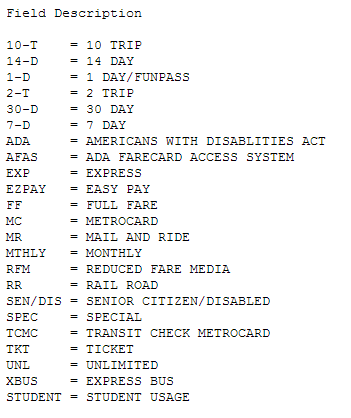

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
# change sklearn.model_selection to cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [2]:
import requests
import urllib
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
# try:
#     import urllib2 as urllib
# except ImportError:
#     import urllib.request as urllib
% matplotlib inline

In [3]:
url = "https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy"
urllib.request.urlretrieve(url,"MTA_Fare.npy")

('MTA_Fare.npy', <http.client.HTTPMessage at 0x7fe2addb70b8>)

In [4]:
!ls

HW10_jl9200_subway_timeseries_instructions2-Copy1.ipynb
HW10_jl9200_subway_timeseries_instructions2.ipynb
MTA_Fare.npy
Ridetypes.png
subway_timeseries_instructions2.ipynb
Untitled.ipynb


In [5]:
mta = np.load("MTA_Fare.npy")

In [6]:
mta.shape

(600, 23, 194)

** test if I can visualize the data into dataframe **

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

### Task 1: 
1. Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. 
2. Identify it and figure out what it is due to.

# read in data as instructed above

In [7]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [38]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [8]:
# reference http://pandas.pydata.org/pandas-docs/stable/generated/pandas.date_range.html
date = pd.date_range('05/21/2010',periods =mta.shape[2],freq = 'W')

In [9]:
date

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [59]:
ridetype

array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
       'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
       'umlim', 'xbus', 'stud'], 
      dtype='<U5')

In [60]:
# y = np.log10(weightedride[i])  x = week 

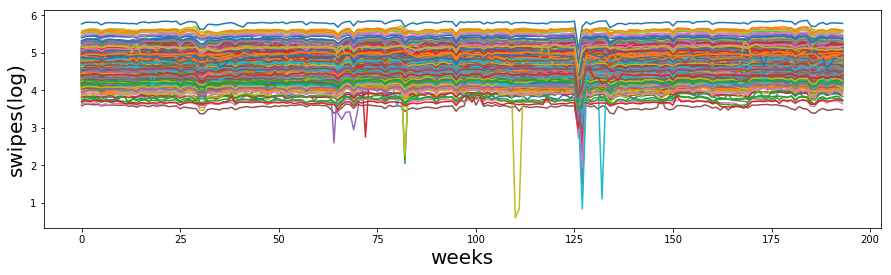

In [10]:
# first attempt
fig = pl.figure(figsize = (15,4))
ax = fig.add_subplot(111)
allrides = []
for i in range(mta.shape[0]):
    riders = [sum(mta[i,:,j]) for j in range(mta.shape[2])]
    if min(riders)>1:
        plt.plot(np.log10(riders))
    else:
        pass
pl.xlabel('weeks',fontsize = 20)
pl.ylabel('swipes(log)',fontsize = 20)
pl.show()

** Figure 1.1: The log of total swipes per week will all types start from 05/19/2010 to 02/19/2014 **

In [44]:
mta[mta == -1].shape

(649563,)

In [ ]:

# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


In [11]:
# need to change the -1 as nan
# reference: how to dynamically update a plot in a loop in ipython notebook (within one cell)
# https://stackoverflow.com/questions/21360361/how-to-dynamically-update-a-plot-in-a-loop-in-ipython-notebook-within-one-cell

mta = mta.astype(float)
mta[mta == -1] = float('NaN')
logmtarides = np.log10(mta)

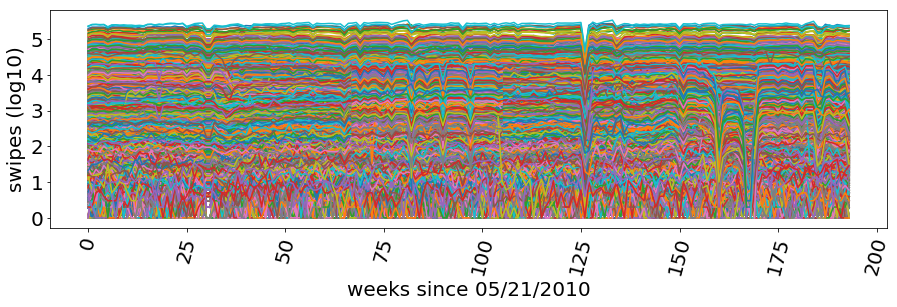

In [12]:
fig = pl.figure(figsize=(15,4))
ax = fig.add_subplot(111)
for j in range(mta.shape[1]):

    display.clear_output(wait=True)
    #display.display(pl.gcf())
    #time.sleep(1) # slow down
    for i in range(mta.shape[0]):
        pl.plot(logmtarides[i,j])
pl.xticks(rotation = 75, fontsize=20)
pl.yticks(fontsize = 20)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel("swipes (log10)", fontsize=20)  
pl.show()

** Figure 1.2: The log of total swipes per week will all types start from 05/19/2010 to 02/19/2014 **

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [64]:
# total trips of each station [0] of sum of each week[2] of each type [1]
len(np.nansum(mta,axis = 0))

23

In [66]:
np.nansum(mta,axis = 0).shape # type[0] week[1]

(23, 194)

In [67]:
# total trips of each station [0_old]  of each week [1] of all types [0]
len(np.nansum(np.nansum(mta,axis = 0),axis = 0))

194

In [68]:
np.nansum(np.nansum(mta,axis = 0),axis = 0).shape # week[0]

(194,)

In [13]:
mtasum_week = np.nansum(np.nansum(mta,axis = 0),axis = 0)

In [14]:
mta_week = np.nansum(np.nansum(mta,axis = 0),axis = 0)

In [15]:
mta_week.shape

(194,)

In [16]:
nan in mtasum_week

False

In [17]:
print ("mean of the total trips of each station of all type per week is {0:.3f} \n\
and standard deviation of mean of the total trips of each station of all type per week is {1:.3f} ".format(np.mean(mtasum_week),np.std(mtasum_week)))

mean of the total trips of each station of all type per week is 29781349.871 
and standard deviation of mean of the total trips of each station of all type per week is 2983960.422 


In [18]:
thresholds = [np.mean(mtasum_week) +3*np.std(mtasum_week),\
             np.mean(mtasum_week)-3*np.std(mtasum_week)]
thresholds

[38733231.136236683, 20829468.606031362]

In [19]:
print("mean swipes per station is {:.2f}\n\
stdev swipes per station is {:.2f}\n\
3-sigma thresholds {:.2f} - {:.2f}".\
      format(np.mean(mtasum_week),\
             np.std(mtasum_week),\
             thresholds[0],\
             thresholds[1]))

mean swipes per station is 29781349.87
stdev swipes per station is 2983960.42
3-sigma thresholds 38733231.14 - 20829468.61


Text(0,0.5,'sum of swipes')

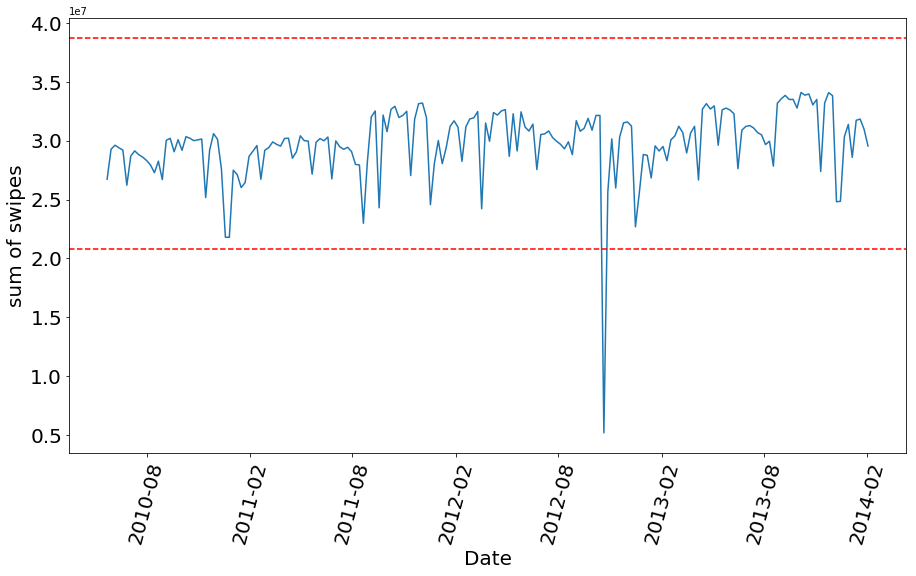

In [20]:
fig = plt.figure(figsize(15,8))
ax = fig.add_subplot(111)
ax.plot(date,mta_week)

plt.axhline(y=thresholds[1], color='red',linestyle = '--')
plt.axhline(y=thresholds[0], color='red',linestyle = '--')
pl.xticks(rotation = 75, fontsize=20)
pl.yticks(fontsize = 20)
pl.xlabel("Date", fontsize=20)
pl.ylabel("sum of swipes", fontsize=20) 

** Figure 1.3: The sum of swipes of all type in one station per week will all types start from 05/19/2010 to 02/19/2014. the two dashlines show the three sigma the threshold. We can see the the deep drop around 2012-08 to 2013-02 **

In [21]:
date[0]

Timestamp('2010-05-23 00:00:00', offset='W-SUN')

In [22]:
# using the np.where(bool) like dataframe.iloc(value<0)
# finalout which is the outliner date
date[np.where(mta_week<thresholds[1])][0]

Timestamp('2012-10-21 00:00:00')

### Actually, when I look up the date online, I found out Oct 21, 2012 is the date before Sandy hit New York

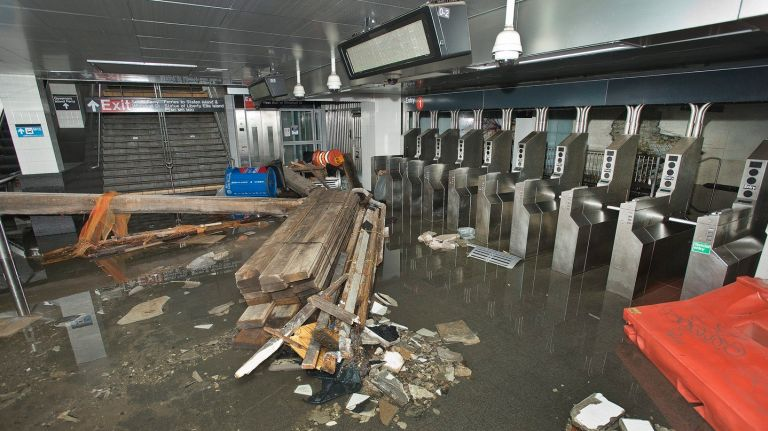

In [78]:
import io
# from PIL import Image no PIL module in ADRF
from IPython.display import Image

Image("https://cdn.newsday.com/polopoly_fs/1.12516778.1477607296!/httpImage/image.jpeg_gen/derivatives/landscape_768/image.jpeg")


 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [23]:
0 in mta

True

In [24]:
-1 in mta

False

In [25]:
# now find the ride type (23)
mta.shape

(600, 23, 194)

In [26]:
mta_type_week = np.nansum(mta,axis = 0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


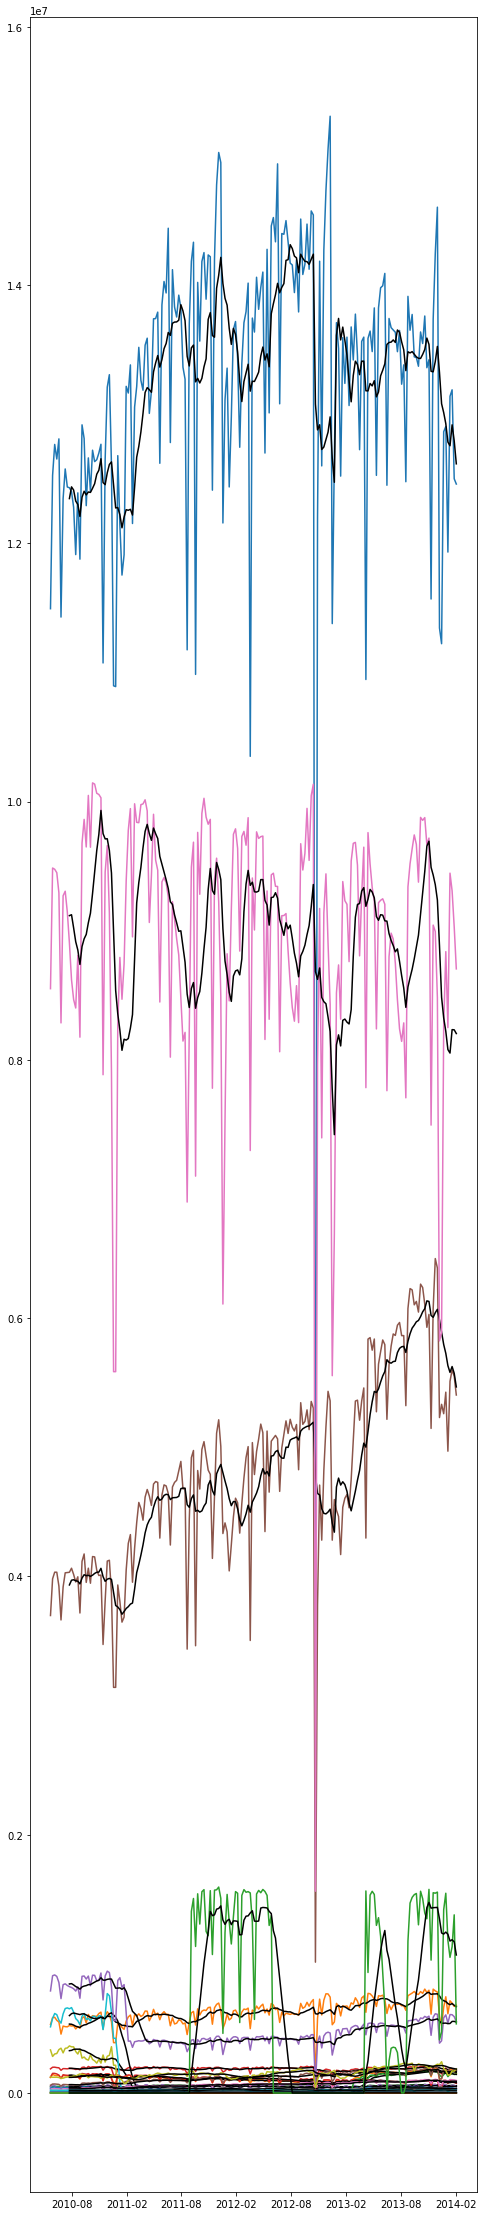

In [27]:
fig = plt.figure(figsize = (8,40))
ax = fig.add_subplot(111)

for i in range(len(mta_type_week)):
    plt.plot(date,mta_type_week[i])
    plt.plot(date,pd.rolling_mean(mta_type_week[i],10),'black')

** Figure 2.1: this is the total swips for each types with rolling mean  **

In [30]:
np.nanstd(pd.rolling_mean(np.nansum(mta[:,0,:], axis=0), 10))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


546777.61699204484

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is depr

0
stdev 546777.62, fractional change over time 1.05: 

1
stdev 64593.90, fractional change over time 1.33: 

2
stdev 5767.41, fractional change over time 1.17: 

3
stdev 8828.00, fractional change over time 0.97: 

4
stdev 3624.09, fractional change over time 1.07: 

5
stdev 631955.02, fractional change over time 1.46: 



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is depr

6
stdev 473487.37, fractional change over time 0.92: 

7
stdev 3794.93, fractional change over time 0.00: 

8
stdev 101444.89, fractional change over time 0.00: 

9
stdev 206370.78, fractional change over time 0.00: 

10
stdev 18800.95, fractional change over time 0.87: 

11
stdev 25371.32, fractional change over time 1.23: 



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is depr

12
stdev 61154.07, fractional change over time 26332.33: 

13
stdev 17282.83, fractional change over time 0.60: 

14
stdev 153165.98, fractional change over time 0.65: 

15
stdev 33309.14, fractional change over time 2.64: 

16
stdev 18139.76, fractional change over time 2.94: 

17
stdev 10350.80, fractional change over time 76.86: 



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is depr

18
stdev 30841.45, fractional change over time 1.66: 

19
stdev 1570.54, fractional change over time 1.06: 

20
stdev 681.42, fractional change over time 0.84: 

21
stdev 252.04, fractional change over time 1.94: 

22
stdev 587158.97, fractional change over time inf: 



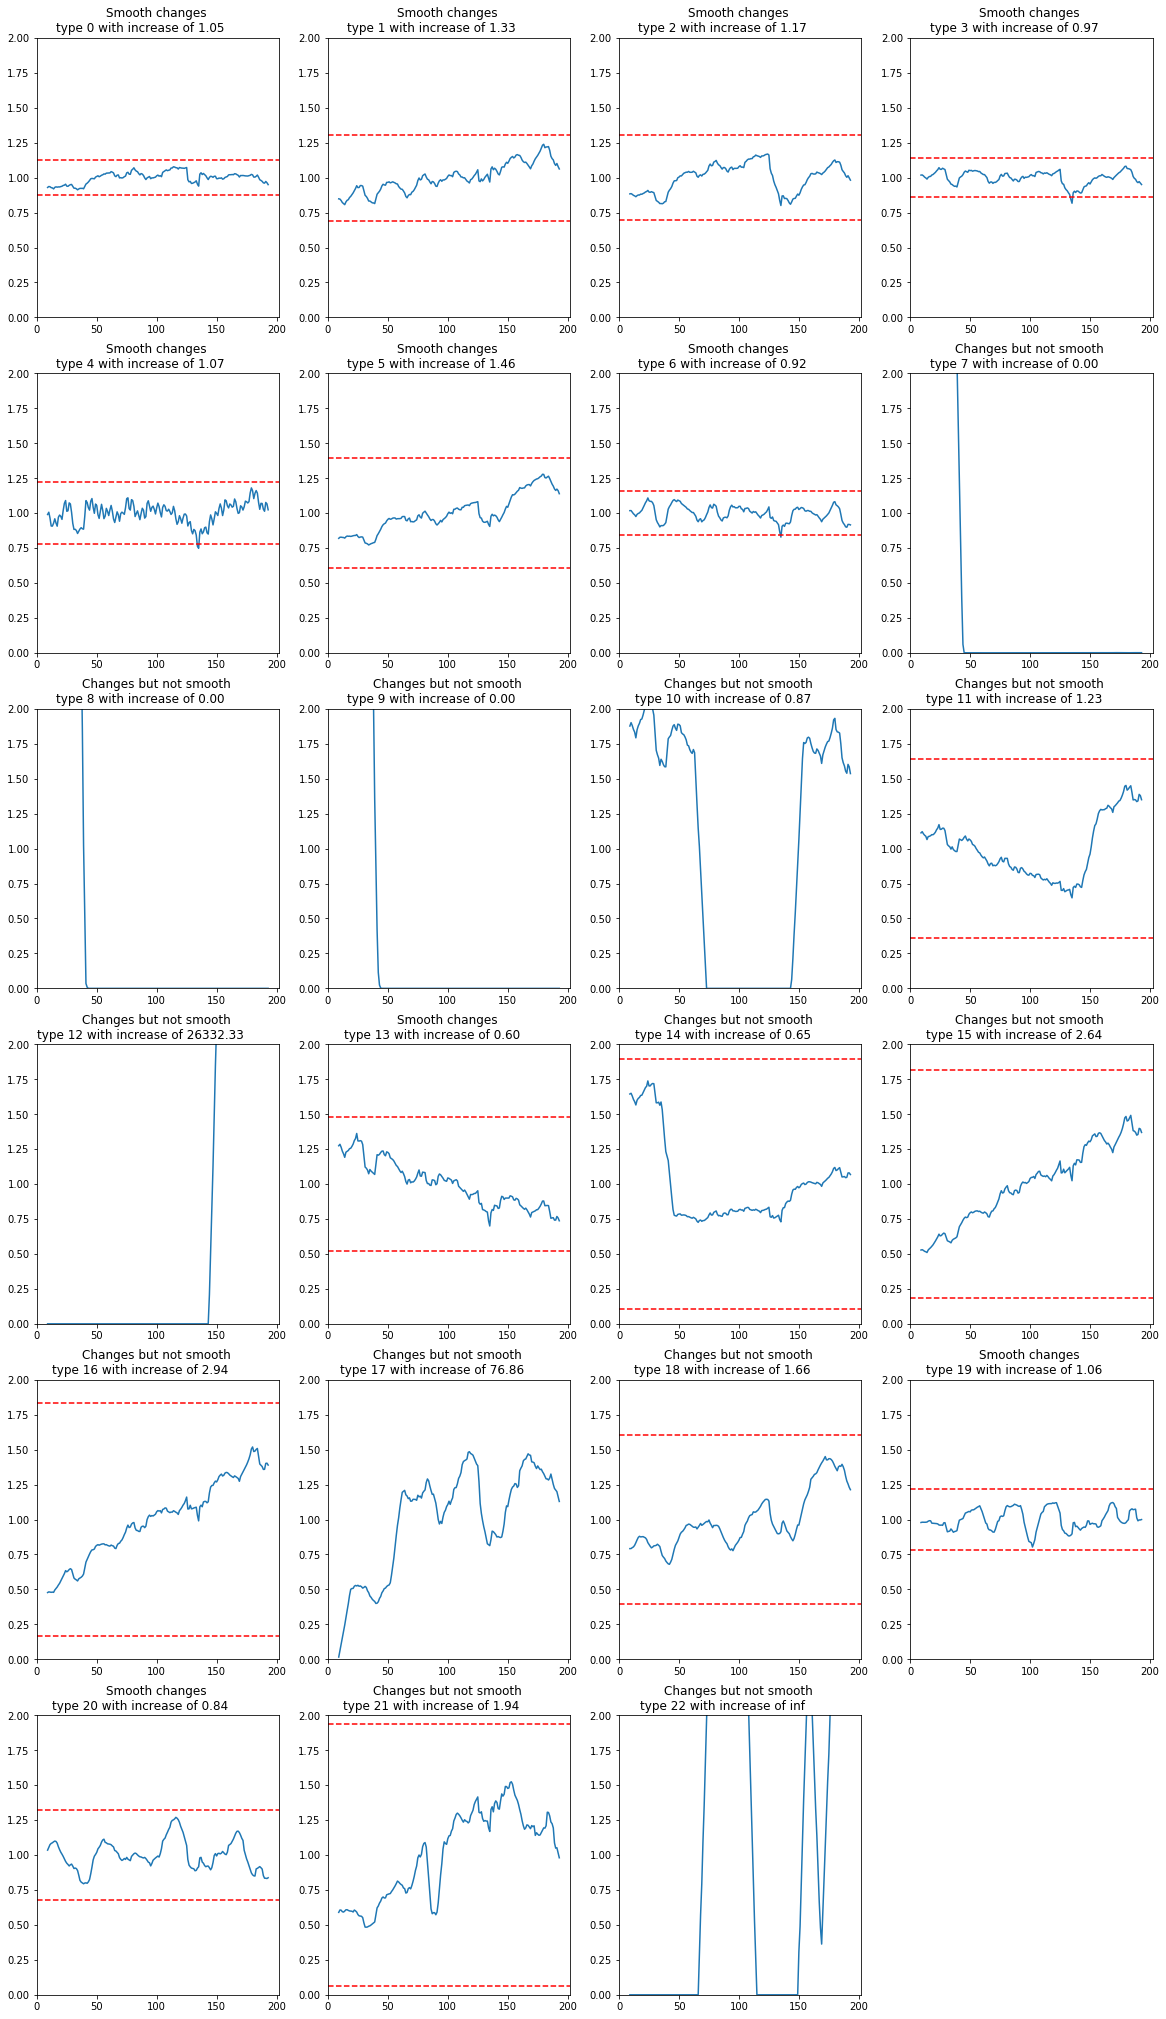

In [31]:
fig = plt.figure(figsize = (20,36))
increase = np.zeros(mta.shape[1])
st = np.zeros(mta.shape[1])

for i in range(mta.shape[1]):
    mta_typerides = mta[:,i,:]
    ax= fig.add_subplot(6,4,i+1)
    mta_typeridesM = pd.rolling_mean(np.nansum(mta[:,i,:],axis = 0),10)
    increase[i] = np.nanmean(mta_typeridesM[-10:])/np.nanmean(mta_typeridesM[:10])
    st[i] = np.nanstd(mta_typeridesM)
    print ("{0}\nstdev {1:.2f}, fractional change over time {2:.2f}: \n".format(i,st[i],increase[i]))
    #print (i,st[i],increase[i])
    plt.plot(mta_typeridesM/np.nanmean(mta_typeridesM))
    threshold = [np.nanmean(mta_typeridesM/np.nanmean(mta_typeridesM))+3*np.nanstd(mta_typeridesM/np.nanmean(mta_typeridesM)),np.nanmean(mta_typeridesM/np.nanmean(mta_typeridesM))-3*np.nanstd(mta_typeridesM/np.nanmean(mta_typeridesM))]
    std = np.nanstd(mta_typeridesM/np.nanmean(mta_typeridesM))
    if std >0.2:
        plt.title("Changes but not smooth \ntype {0} with increase of {1:.2f} \
        ".format(i,increase[i]))
    else:
        plt.title("Smooth changes \ntype {0} with increase of {1:.2f} \
        ".format(i,increase[i]))
    plt.axhline(threshold[1],color = 'red',linestyle = '--')
    plt.axhline(threshold[0],color = 'red',linestyle = '--')
    plt.ylim(0,2)
    

** Figure 2.2: These 23 plots are of each type with trend of increase to determine which one is steepest increase and steepest decrease **

In [390]:
for i in range(len(increase)):
    print (" (increase -1) of type {0} is {1:.2f}: ".format(i,increase[i]-1))

 (increase -1) of type 0 is 0.05: 
 (increase -1) of type 1 is 0.33: 
 (increase -1) of type 2 is 0.17: 
 (increase -1) of type 3 is -0.03: 
 (increase -1) of type 4 is 0.07: 
 (increase -1) of type 5 is 0.46: 
 (increase -1) of type 6 is -0.08: 
 (increase -1) of type 7 is -1.00: 
 (increase -1) of type 8 is -1.00: 
 (increase -1) of type 9 is -1.00: 
 (increase -1) of type 10 is -0.13: 
 (increase -1) of type 11 is 0.23: 
 (increase -1) of type 12 is 26331.33: 
 (increase -1) of type 13 is -0.40: 
 (increase -1) of type 14 is -0.35: 
 (increase -1) of type 15 is 1.64: 
 (increase -1) of type 16 is 1.94: 
 (increase -1) of type 17 is 75.86: 
 (increase -1) of type 18 is 0.66: 
 (increase -1) of type 19 is 0.06: 
 (increase -1) of type 20 is -0.16: 
 (increase -1) of type 21 is 0.94: 
 (increase -1) of type 22 is inf: 


** To find the steepest increase, and the steepest decrease. I will use the (increase - 1) to measure how far it away from 0, Also, I will roll-out the type 7,8,9 of -1 because the increase is 0 and also the type 12 and type 22 with inf. Thus I found that the type 13 is the steepest decrease and type 17 is the steepest increase **

13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


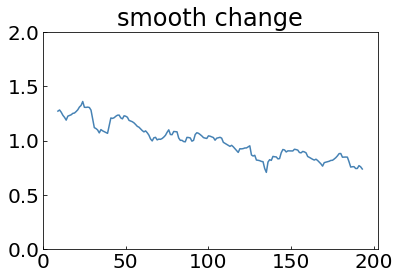

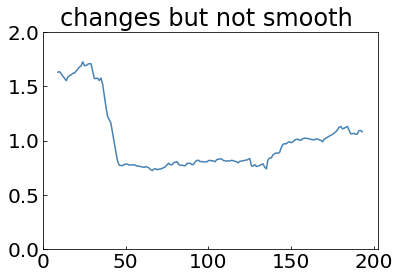

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

1. Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

2. Plot a confusion matrix for each model (discuss)

3. Compare the models using sklearn.metrics classification_report

4. Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [281]:
mta = np.load("MTA_Fare.npy")

# reference: https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array
# np.where(np.isfinite(x), x, 0)
# mtatest = np.where(np.isfinite(mta), mta, 0)

In [282]:
mta = mta.astype(float)
# mta[mta == -1] = float('NaN')

In [283]:
label = np.tile(range(0,23),mta.shape[0])

In [284]:
label.shape

(13800,)

In [285]:
label = label[mta.reshape(600*23,194).std(1)>0]

In [286]:
label.shape

(9317,)

In [287]:
# mta = mta.astype(float)
# mta[mta == -1] = float('NaN')

In [288]:
stationsmeans = np.nanmean(np.nanmean(mta,axis = 1),axis = 1)

In [289]:
stationsmeans.shape

(600,)

In [290]:
len(mta[:,0,:])

600

In [291]:
mta.shape[0]

600

In [292]:
range(mta.shape[0])

range(0, 600)

In [293]:
mta.shape[0]

600

In [294]:
std = np.zeros(mta.shape[0])
for i in range(mta.shape[0]):
    std[i] =np.nanstd(mta[i,:,:])

In [295]:
stationsstd = std

In [296]:
stationsstd.shape

(600,)

In [297]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [355]:
tots = mta.reshape(600*23,194)[mta.reshape(600*23, 194).std(1) > 0]
tots.shape

(9317, 194)

In [312]:
tots_n = (tots-np.nanmean(tots))/np.nanstd(tots)

In [313]:
normed_time_series_std = [np.nanstd(tots_n[i]) for i in range(mta.shape[2])]

In [314]:
normed_time_series_mean = [np.nanmean(tots_n[i]) for i in range(mta.shape[2])]

In [361]:
normed_time_series_std[:10]

[1.526134168676935,
 0.044296911246060458,
 0.0057682245243447297,
 0.016432042269149336,
 0.011729147549398007,
 0.51112748845137057,
 0.85507786835130606,
 0.0015285387390501905,
 0.18878158550996985,
 0.080889239446978872]

In [362]:
tsmean = np.nanmean(tots,axis = 1)
tsmean.shape

(9317,)

In [363]:
tsmean[:10]

array([  5.79828866e+04,   1.80932474e+03,   2.34865979e+02,
         7.30041237e+02,   2.90108247e+02,   1.98267680e+04,
         3.02422629e+04,   8.47422680e+00,   9.67087629e+02,
         4.26824742e+02])

In [364]:
tsstdev = np.nanstd(tots,axis = 1)

In [365]:
tsstdev[:10]

array([ 18634.01356896,    540.86282986,     70.42970157,    200.63432488,
          143.21224115,   6240.83828981,  10440.45335489,     18.66337324,
         2305.01269034,    987.653128  ])

In [336]:
len(tsmean)

9317

In [344]:
len(tsstdev)

9317

In [338]:
range(tots.shape[0])

range(0, 9317)

In [383]:
# not working
# standardizedts = np.zeros(tots.shape[0])
# for i in range(tots.shape[0]):
#     standardizedts[i]=(tots[i]-tsmean[i])/tsstdev[i]

In [386]:
# try the list
standardizedts = []
for i in range(tots.shape[0]):
    standardizedts.append((tots[i]-tsmean[i])/tsstdev[i])
standardizedts = np.array(standardizedts)

In [388]:
standardizedts.shape

(9317, 194)

Text(0,0.5,'standardized number of rides')

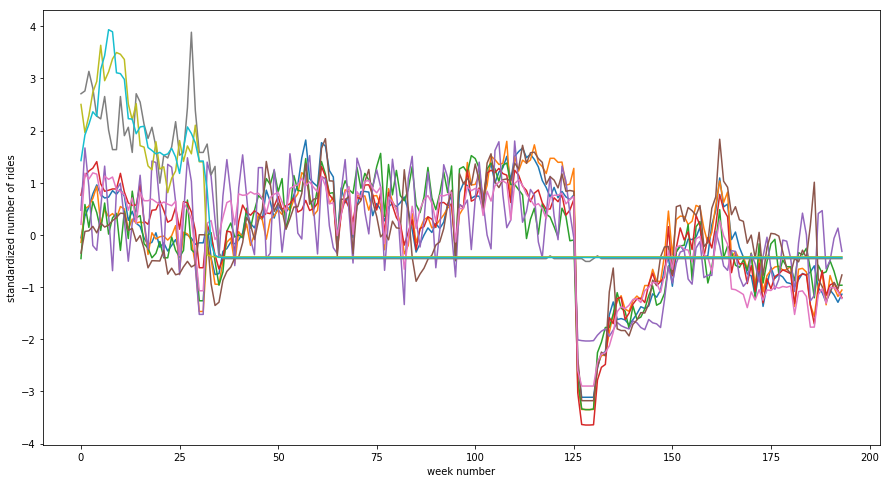

In [391]:
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

** figure 3.1: plot for the standardized timeseries data each type **

In [584]:
x = range(tots.shape[1])

In [585]:
x

range(0, 194)

In [586]:
X = sm.add_constant(x)

In [587]:
allfits = [sm.OLS(tots[i],X).fit() for i in range(tots.shape[0])]

In [588]:
[a.params[0] for a in allfits[:10]]

[71890.848691514664,
 2091.2375892149084,
 282.7639968279143,
 915.91720856463098,
 407.48564631245029,
 21297.249484536078,
 41997.967486122114,
 29.473909595559071,
 3439.0558287073736,
 1505.7963521015063]

You can use the sklearn train_test_split() function to create your training and test dataset.

In [604]:
totsT  = tots.T

In [717]:
totsT.shape

(194, 9317)

In [718]:
range(totsT.shape[1])

range(0, 9317)

In [721]:
x = range(totsT.shape[0])
X = sm.add_constant(x)
allfits1 = []
for i in range(totsT.shape[1]):
    allfits1.append(sm.OLS(totsT[:,i],X).fit())

In [722]:
allfit1=np.array(allfits1)

In [725]:
totsT[1][1]

2083.0

In [726]:
totsT[0][3]

883.0

In [727]:
np.where(totsT==72628.0)

(array([3]), array([0]))

In [728]:
np.where(totsT==float('Inf'))

(array([], dtype=int64), array([], dtype=int64))

In [729]:
np.where(totsT==float('NaN')) 

(array([], dtype=int64), array([], dtype=int64))

In [730]:
totsT.shape

(194, 9317)

In [731]:
label.shape

(9317,)

In [732]:
totsT_n = (totsT-np.nanmean(totsT))/np.nanstd(totsT)

In [733]:
len(totsT_n[:,1])

194

In [734]:
normedtsmean = [np.nanmean(totsT_n[:,i]) for i in range(totsT.shape[1])]

In [735]:
normedtsstd = [np.nanstd(totsT_n[:,i]) for i in range(totsT.shape[1])]

In [736]:
data = np.array([[a.params[0] for a in allfits1], [a.params[1] for a in allfits1], 
              np.mean(totsT)/normedtsmean, np.std(totsT)/normedtsstd]).T

In [737]:
data.shape

(9317, 4)

In [738]:
import sklearn
print(sklearn.__version__) 

0.17.1


In [739]:
label.shape

(9317,)

In [740]:
# Shuffle = True is not working because the sklearn version is to low
X_train, X_test, y_train, y_test = train_test_split(data,label,test_size = 0.33,random_state = 42)

In [741]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

In [742]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [ ]:
# reference:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [743]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.datasets import make_classification

# rfr = ensemble.RandomForestClassifier()

In [702]:
# no need to use X_train, y_train = make_classification(n_samples=1000)

In [756]:
# reference https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# input n_estimators
clf = rfc(n_estimators=400)

In [757]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [758]:
X_train.shape

(6242, 4)

In [759]:
X_test.shape

(3075, 4)

In [760]:
y_pred = clf.predict(X_test)

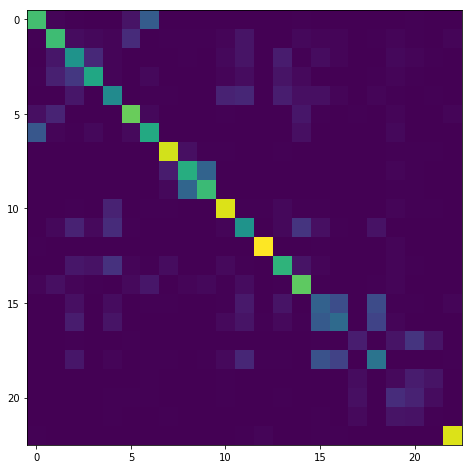

In [761]:
imshow(confusion_matrix(y_test,y_pred))

** figure 4.1: This image show the confusion matrix of  y_test vs y_pred, which show the how good the prediction for each type of swipe. Now we can see for type 7, 10, 12 and 23 might have better accuracy I guess **

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [765]:
tots.shape

(9317, 194)

In [766]:
label.shape

(9317,)

In [767]:
# use the same split ratio
X1_train, X1_test, y1_train, y1_test = train_test_split(tots,label,test_size = 0.33,random_state = 42)

In [768]:
clf2 = rfc(n_estimators=400)

In [769]:
clf2.fit(X1_train,y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [770]:
y1_pred = clf2.predict(X1_test)

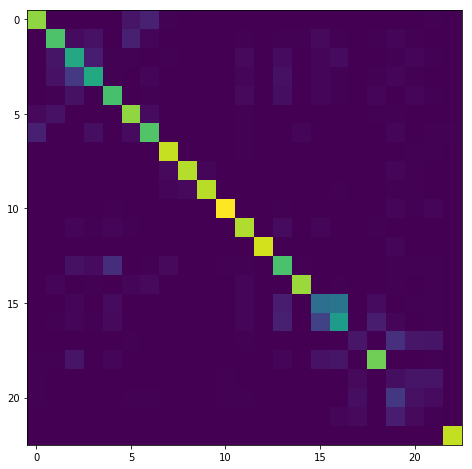

In [771]:
imshow(confusion_matrix(y1_test,y1_pred))

** figure 4.2: This image show the confusion matrix of  y1_test vs y1_pred, which show the how good the prediction for each type of swipe. For me, it's very hard to figure out which model is better by eyes, I will compare the report to determine which one is better **

In [773]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.67      0.65      0.66       160
        14d       0.67      0.65      0.66       157
         1d       0.45      0.54      0.49       141
         2t       0.72      0.57      0.64       154
        30d       0.48      0.50      0.49       142
         7d       0.75      0.74      0.74       154
        ada       0.58      0.60      0.59       149
       afas       0.85      0.92      0.88       150
        exp       0.61      0.60      0.61       153
         ez       0.66      0.66      0.66       154
         ff       0.77      0.83      0.80       168
         mc       0.49      0.48      0.49       157
         mr       0.97      0.97      0.97       152
      month       0.64      0.60      0.62       159
        rfm       0.64      0.74      0.69       151
         rr       0.30      0.30      0.30       151
        sen       0.41      0.31      0.36       162
       spec       0.43      0.23      0.30   

In [774]:
print(classification_report(y1_test, y1_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.86      0.84      0.85       160
        14d       0.79      0.74      0.77       157
         1d       0.61      0.69      0.64       141
         2t       0.74      0.64      0.69       154
        30d       0.75      0.80      0.78       142
         7d       0.80      0.87      0.83       154
        ada       0.79      0.79      0.79       149
       afas       0.92      0.98      0.95       150
        exp       0.97      0.93      0.95       153
         ez       0.98      0.94      0.96       154
         ff       0.98      0.96      0.97       168
         mc       0.85      0.90      0.88       157
         mr       1.00      0.99      0.99       152
      month       0.68      0.72      0.70       159
        rfm       0.97      0.91      0.94       151
         rr       0.53      0.39      0.45       151
        sen       0.52      0.55      0.53       162
       spec       0.42      0.19      0.26   

### Conclusion


1. The Precision = (TP)/(TP + FP) meaning How many selected item are relevant  
2. Recall = (TP)/(TP + FN) How many relevant items are select? 

3. F1-score = 2 * (precision * recall) / (precision + recall) F1 score conveys the balance between the precision and the recall. Thus, if we were looking to select a model based on a balance between precision and recall, the F1 measure suggests that All Recurrence model is the one to beat and that CART model is not yet sufficiently competitive

**Throught the comparison of the precision,recall and f1-score, I believe the second model is better classification **

In [776]:
## reference: Class10 Note 
## reference: https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5464762/